# Survival kit for ML coding interviews 

This notebook handles oldies but goodies of machine learning, often asked in ML/Optimization interviews. It aims to implement the most classic ML algorithms and some well-known variants, while also tackling key theoretical aspects one should keep in mind during an interview. Some questions may be tricky and thought-provoking.

It's an ongoing project, thus not comprehensive. It gathers some topics I, or some friends of mine, faced during actual interviews. 

Some explanations might be inaccurate or not extremely rigorous, but I'll let them as is because it makes sense to me. In addition, most of the experiments are quite dumd (2D in most cases) but they allow interpretable plots. However, the proposed implementations correspond more to real-world frameworks (higher dimensions and more data). For instance, using stochastic optimization methods is overkill when dealing with a few hundreds of 2D points.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torch.optim import SGD
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam

from sklearn.datasets import make_blobs

from tqdm import tqdm

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

## K-MEANS

K-Means is an unsupervised clustering algorithm. It aims to minimize the intra-class variance:

$$\mathcal{L} = \sum_{i=1}^k \sum_{x\in \mathcal{C_i}} \|x-\mu_i\|_2^2$$

Where:
- Clusters are indexed by $\{1,...,k\}$
- $C_i$ is the set of points in cluster $i$
- $\mu_i$ is the barycenter of cluster $i$

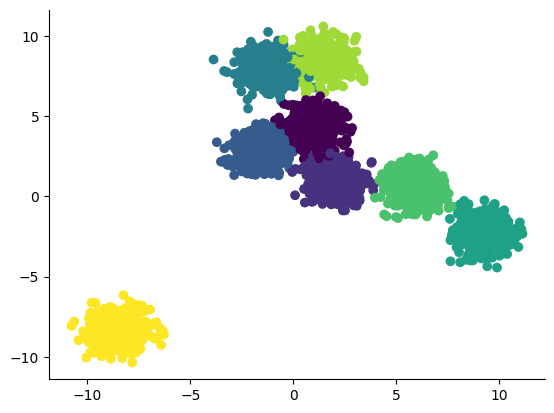

In [2]:
n_clusters = 8
n_samples = 4000
X, y, centers = make_blobs(n_samples=n_samples, 
                           centers=n_clusters, 
                           n_features=2, 
                           cluster_std=0.7,
                          return_centers=True)
plt.figure()
plt.scatter(X[:,0], X[:,1], c =y)
plt.show()

In [3]:
def compute_loss(X, labels, centroids, n_clusters):
    """
    X: (n_samples, 2)
    Y: (n_samples,)
    """
    loss = 0
    for i in range(n_clusters):
        loss += np.sum(np.linalg.norm(X[labels==i] - centroids[i][None,:], axis=1)**2)
    return loss

def compute_distance(X, centroids):
    return np.linalg.norm(X[:,None,:] - centroids[None,:,:], axis=2)

def kmeans(X, n_clusters, max_iter=10, tol=5, init=None):
    n_samples, dim = X.shape
    losses = []
    all_centroids = []
    all_labels = []
    
    if init is None: 
        centroid_indices = np.random.choice(range(n_samples), size=n_clusters, replace=False)
        init = X[centroid_indices]

    curr_loss = 1e8
    centroids = init
    for i in tqdm(range(max_iter)):
        # Compute distances
        distances = compute_distance(X, centroids) # (n_samples, n_centroids)
        labels = distances.argmin(axis=1) # (n_samples,)
        curr_loss = compute_loss(X, labels, centroids, n_clusters)

        for i in range(n_clusters):
            centroids[i] = np.mean(X[labels==i], axis=0)

        losses.append(curr_loss)
        all_labels.append(labels)
        all_centroids.append(centroids)

    return all_labels, all_centroids, losses

In [4]:
all_labels, all_centroids, losses = kmeans(X, n_clusters=n_clusters, max_iter=10)

100%|██████████| 10/10 [00:00<00:00, 699.05it/s]


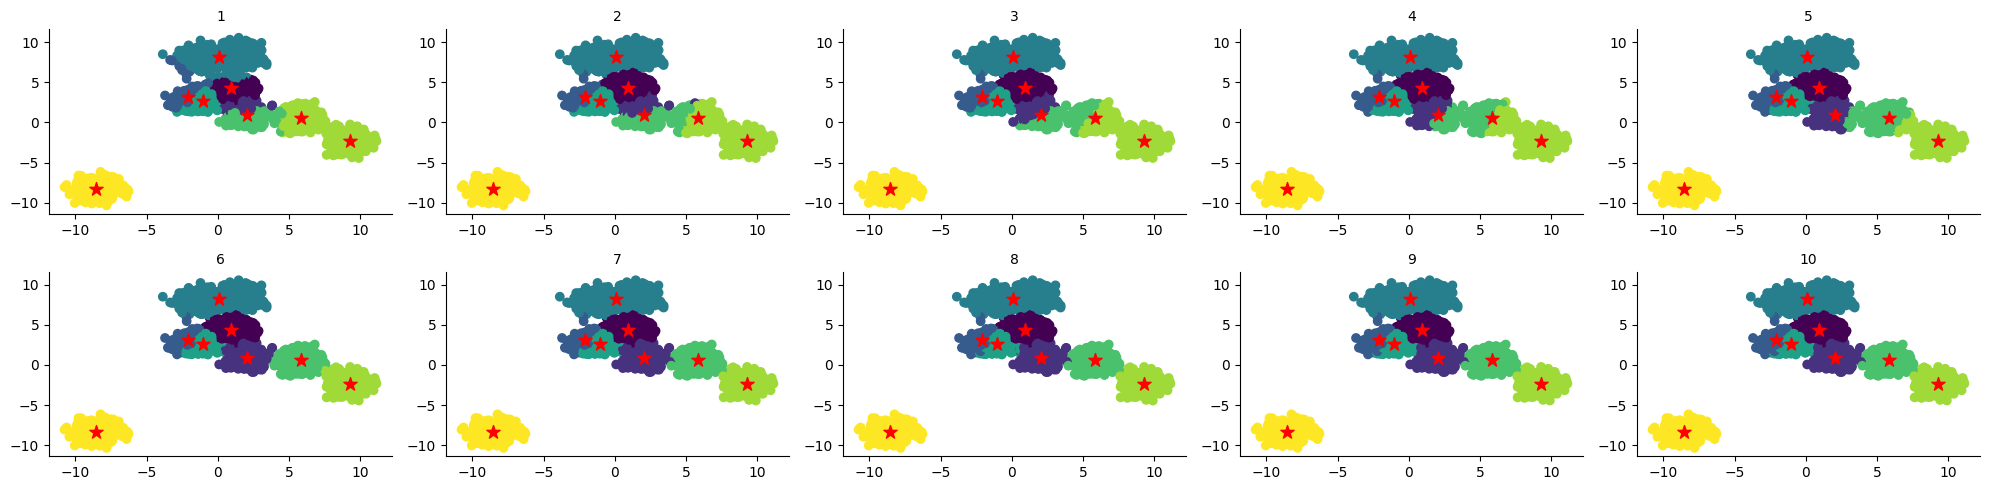

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5))
ax = axes.ravel()

for i, (curr_ax, labels, centroids) in enumerate(zip(ax, all_labels, all_centroids)):
    curr_ax.scatter(X[:,0], X[:,1], c=labels)
    curr_ax.scatter(centroids[:,0], centroids[:,1], marker='*', s=100, c='red')
    curr_ax.set_title(f'{i+1}', fontsize=10)
plt.tight_layout()
plt.show()

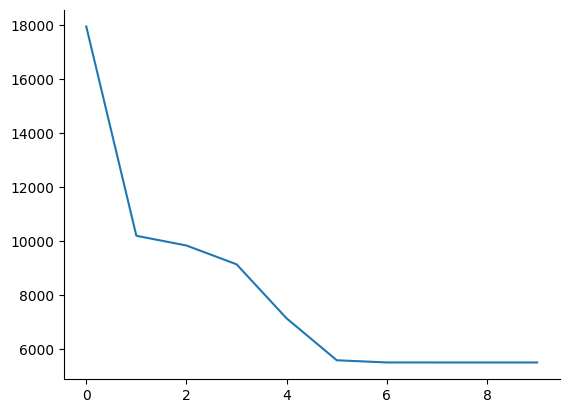

In [6]:
plt.figure()
plt.plot(losses)
plt.show()

## MLE methods

*with gradient descent or other optimization schemes* (but no closed form although they exist)

### Linear Regression

In [7]:
dim = 15
n_samples = 3000
theta_gt = 2 * torch.rand(dim + 1, 1) -1 # intercept

X = 20 * torch.rand(n_samples, dim) - 10
eps = 3.5 * torch.randn(n_samples, 1)
Y = X @ theta_gt[:-1] + theta_gt[-1] + eps

Using SGD


100%|██████████| 500/500 [00:00<00:00, 8064.02it/s]


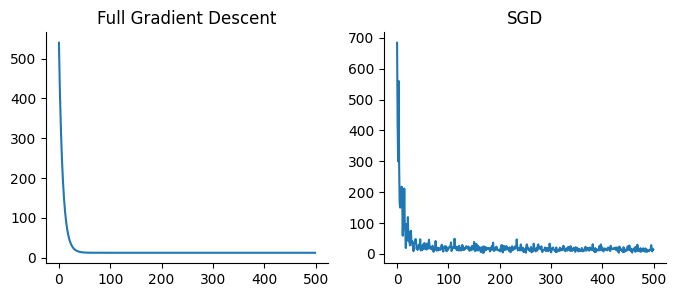

In [8]:
use_sgd = True
loss_fn = nn.MSELoss()

def optimize(X_gt, Y_gt, n_epochs, lr, use_sgd=False, batch_size=50):
    if use_sgd: print('Using SGD')
    n_samples, dim = X_gt.shape
    losses = np.zeros(n_epochs)

    theta = torch.randn(dim+1, 1, requires_grad=True)
    
    for epoch in tqdm(range(n_epochs)):
        if use_sgd:
            sample_idx = torch.randint(n_samples, (batch_size,))
            X_sample = X_gt[sample_idx,:]
            Y_sample = Y_gt[sample_idx]
            Y_pred = X_sample @ theta[:-1] + theta[-1]
            loss = loss_fn(Y_pred, Y_sample)
        else:
            Y_pred = X_gt @ theta[:-1] + theta[-1]
            loss = loss_fn(Y_pred, Y_gt)
        
        loss.backward()
        
        with torch.no_grad():
            theta -= lr * theta.grad
        if use_sgd: lr *= 0.999

        theta.grad.zero_()
        losses[epoch] = loss.item()
        
    return theta.detach(), losses

theta_pred_sgd, losses_sgd = optimize(X, Y, n_epochs=500, lr=1e-3, use_sgd=True, batch_size=10)
theta_pred, losses = optimize(X, Y, n_epochs=500, lr=1e-3, use_sgd=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1.plot(losses)
ax1.set_title('Full Gradient Descent')
ax2.plot(losses_sgd)
ax2.set_title('SGD')
plt.show()

### Logistic regression

We play around with first and second order optimization schemes. For second order with stick with quasi-Newton methods (i.e. involving approximate Hessian instead of the the exact one)

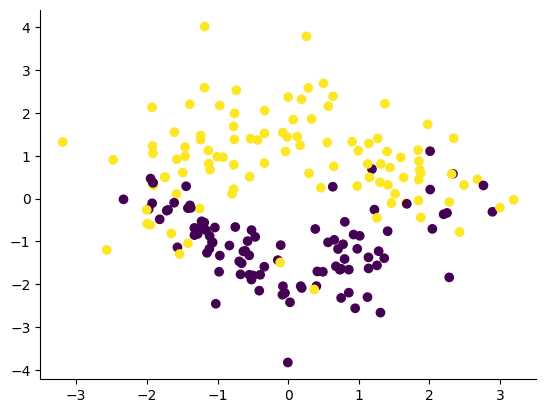

In [9]:
from sklearn.datasets import make_classification

n_samples = 200
dim = 2

X, y = make_classification(n_samples=n_samples, 
                           n_features=dim,
                           n_redundant=0
                          )

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [10]:
loss_fn = nn.BCELoss()

def optimize_SGD(X, y, lr, n_epochs):
    n_samples, dim = X.shape
    w = torch.zeros(dim+1, requires_grad=True)

    losses = np.zeros(n_epochs)
    
    for epoch in tqdm(range(n_epochs)):
        logits = X @ w[:-1] + w[-1]
        y_pred = torch.sigmoid(logits)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        losses[epoch] = loss.item()
        
        with torch.no_grad():
            w -= lr * w.grad

        w.grad.zero_()
        
    return w, losses


def optimize_LBFGS(X, y, lr, n_epochs, max_iter):
    n_samples, dim = X.shape
    w = torch.zeros(dim+1, requires_grad=True)

    optimizer = torch.optim.LBFGS([w], lr=lr, max_iter=max_iter)       
    losses = np.zeros(n_epochs)

    def closure():
        optimizer.zero_grad()
        logits = X @ w[:-1] + w[-1]
        y_pred = torch.sigmoid(logits)
        loss = loss_fn(y_pred, y)
        loss.backward()
        return loss
    
    for epoch in tqdm(range(n_epochs)):
        loss = optimizer.step(closure)
        losses[epoch] = loss.item()
        
        with torch.no_grad():
            w -= lr * w.grad

        w.grad.zero_()
        
    return w, losses


w_sgd, losses_sgd = optimize_SGD(X, y, lr=1.0, n_epochs=50)
w_lbfgs, losses_lbfgs = optimize_LBFGS(X, y, lr=0.1, n_epochs=10, max_iter=10)

100%|██████████| 10/10 [00:00<00:00, 161.80it/s]


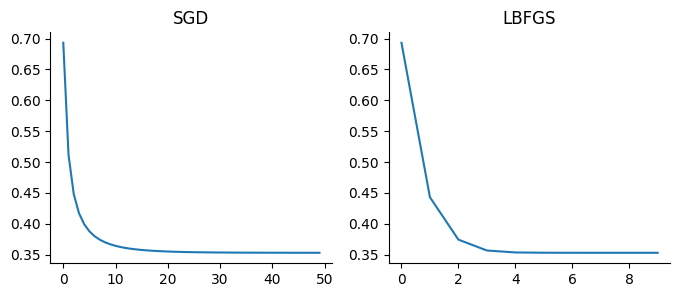

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(losses_sgd)
ax1.set_title('SGD')
ax2.plot(losses_lbfgs)
ax2.set_title('LBFGS')
plt.show()

In [12]:
n_grid_samples = 100
x_grid, y_grid = torch.meshgrid(torch.linspace(X[:,0].min()-1,X[:,0].max()+1, n_grid_samples), torch.linspace(X[:,1].min()-1,X[:,1].max()+1, n_grid_samples))
points = torch.vstack([x_grid.flatten(), y_grid.flatten()])

/home/louis/dev/python/.venv/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


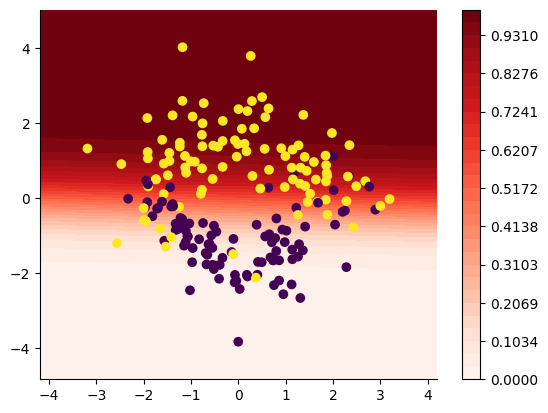

In [13]:
logits = points.T @ w_sgd[:-1] + w_sgd[-1]
prob = torch.sigmoid(logits)
prob = prob.view(x_grid.shape)

plt.figure()
levels = np.linspace(0, 1, 30)
CS = plt.contourf(x_grid.numpy(), y_grid.numpy(), prob.detach().numpy(), levels=levels, cmap='Reds')
plt.colorbar(CS)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')
plt.show()

## MAP methods

The corner stone  of the following algorithms/methods is the Bayes theorem:

$$p(x\mid y)=\frac{p(y\mid x)p(x)}{p(y)}$$

Vocab:
- $p(x\mid y)$ : posterior
- $p(y\mid x)$ : likelihood
- $p(x)$ : prior
- $p(y)$ : marginal

Since the marginal doesn't depend on the variable of interest $x$, we just stick with $p(x\mid y)\propto p(y\mid x)p(x)$. (+ $p(y)$ is hard to compute)

### Naive Bayes

Naive Bayes is commonly used a for basic NLP tasks (spam detection, sentiment analysis, etc.). Given a data point to classifiy, this method gives us class this point is most likely to belong. Formally speaking:

$$c^*=\arg \max_c p(c\mid x) \propto p(x\mid c) p(c)$$

We thus need to estimate:
1. a prior on the class distribution $p(c)$
2. a likelihood distribution of observing $x$ given class $c$

To do so Naive Bayes relies on two strong assumptions:
- **Data in unordered**: In NLP tasks, words are manipulated regardless of their position in the text of the dataset (bag-of-words fashion). Classification is only based on the frequency of each word.
- **Naive assumption**: Let's assume that $x = (x_1, ..., x_p)$ is $p$-dimensional vector. Typically, a feature $x_i$ is a word in NLP tasks. the likelihood term can be rewritten as follows:
$$p(x\mid c) = p(x_1, ..., x_p\mid c)$$
computing this joint probability is tedious without any further assumption. Hence, we **naively** assume that all the features are independant. In this case the likelihood boils down to:
$$p(x_1, ..., x_p\mid c)=\prod_{i=1}^p p(x_i\mid c)$$
The latter product can be easily estimated as the frequency o 

Practical implementation:


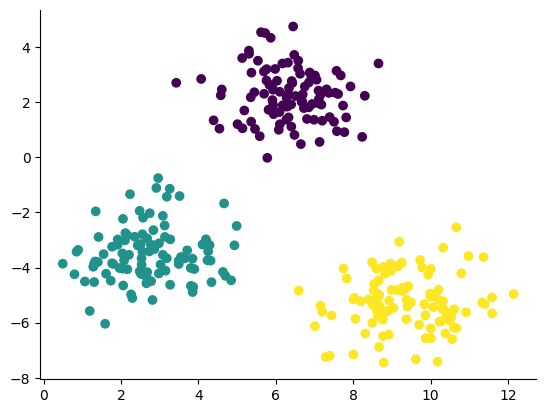

In [14]:
n_samples = 300
n_features = 2
n_classes = 3

X, y, centers = make_blobs(n_samples=n_samples, 
                           centers=n_classes, 
                           n_features=n_features, 
                           cluster_std=1.0,
                          return_centers=True)

plt.figure()
plt.scatter(X[:,0], X[:,1], c =y)
plt.show()

In [15]:
class GaussianNaiveBayes:

    def _logpdf(self, x, c):
        return (-(x-self.means[c]) ** 2) / (2*self.std[c]) # -> (feature1, feature2) one gaussian distribution per feature

    def fit(self, X, y):
        self.n_samples, self.n_features = X.shape
        self.n_classes = len(np.unique(y))
        
        self.priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.std = np.zeros((n_classes, n_features))

        for c in range(self.n_classes):
            samples = X[y==c]
            
            self.priors[c] = len(samples) / n_samples
            self.means[c] = samples.mean(axis=0)
            self.std[c] = samples.var(axis=0, ddof=1)
        self.log_priors = np.log(self.priors)
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        posteriors = np.zeros((X.shape[0], self.n_classes))
            
        for c in range(self.n_classes):
            log_features_likelihood = self._logpdf(X, c)
            log_likelihood = log_features_likelihood.sum(axis=1)
            posterior = self.log_priors[c] + log_likelihood
            posteriors[:,c] = posterior

        y_pred = posteriors.argmax(axis=1)
        return y_pred

bayes_cls = GaussianNaiveBayes()
bayes_cls.fit(X, y)

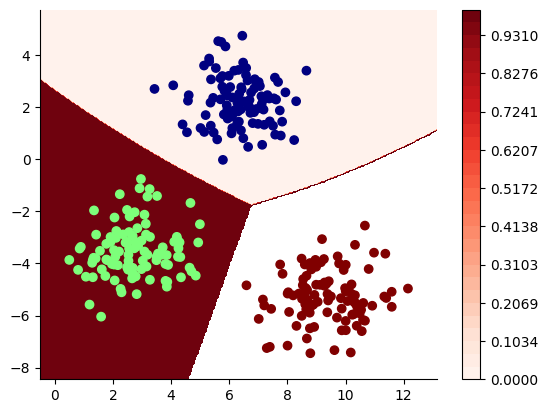

In [16]:
n_grid_samples = 300
x_grid, y_grid = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, n_grid_samples), np.linspace(X[:,1].min()-1, X[:,1].max()+1, n_grid_samples))
points = np.stack([x_grid.flatten(), y_grid.flatten()], axis=-1)

cls = bayes_cls.predict(points).reshape(x_grid.shape)

plt.figure()
levels = np.linspace(0, 1, 30)
CS = plt.contourf(x_grid, y_grid, cls, levels=levels, cmap='Reds')
plt.colorbar(CS)
plt.scatter(X[:,0], X[:,1], c=y, cmap='jet')
plt.show()

### Regularization methods

Those methods, like L1 or L2 penalty terms are actually MAP methods. Although a problem such as Linear Regression is solved with MLE, reguralization actually comes from a prior knowledge on the parameters. (It's obvious afterwards, but I had never seen it under that framework before). An in-depth explanation can be found [in these slides from Tommi Jaakkola (CSAIL)](http://www.ai.mit.edu/courses/6.867-f04/lectures/lecture-6-ho.pdf).

Let's take the example of **Linear Regression model**. We are given a dataset $\{(x_i, y_i)\}_{i=1}^n$ and we want to find $\theta$ such that:

$$y_i = \theta^T x_i + \epsilon_i$$

where $\epsilon_i \sim  \mathcal{N}(0,\sigma^2)$. Hence:
$$y_i\mid x_i, \theta  \sim \mathcal{N}(\theta^Tx_i,\sigma^2)$$

As we actually aim to minimize the neg-log-likelihood, we end-up with the regular expression of the objective function: 

$$\theta^*=\arg \min_\theta \|X\theta-Y\|_2^2$$

Now if we assume **a priori** that $\theta_i \sim \mathcal{N}(0,\sigma^2), i = 1, ..., p$, the prior distribution becomes:

$$p(\theta) \propto\exp\left(-\frac{1}{2\sigma^2} \|\theta\|_2^2\right)$$

Recalling the MAP expression, directly derived from the Bayes theorem:

$$p(\theta\mid X,Y) \propto p(Y\mid X,\theta\,)p(\theta)$$

Once again we minimize the neg-log-likelihood, thus leading to:

$$\boxed{\theta^* = \arg\min_\theta \|X\theta-Y\|_2^2 + \frac{1}{2\sigma^2} \|\theta\|_2^2}$$

and we get the expression of the Ridge model.

Lasso is derived using a Laplace distribution as a prior on the parameters.

## Funny optimization problems

### Computing the inverse of a matrix

This problem is traditionally solved with matrix decomposition algorithm (Cholesky, QR, LU, SVD). But it can also be formulated as an optimization problem, and thus solved using classical optimization schemes. This approach is particularly useful in high dimension. Algorithms relying on matrix decomposition are generally in $O(n^3)$.

Given a matrix $A \in \mathbb{R}^{n\times n}$, the optimization problem can be formulated as follows:

$$A^{-1}=\arg \min_X \|AX-I\|_2^2$$

This problem is (strongly) convex, so any decent numerical solver should converge a global minimum. 

**Note on the invertibility of a matrix**.  
Although one should ensure that the matrix at stake is invertible, one recall that non invertible matrices are extremely rare. A matrix $A$ isn't invertible if and only if $\det(A)=0$. Since the determinant is a linear form, it's continuous. In particular, it's polynomial with respect to each coefficient of the matrix. Hence, with a randomly chosen matrix, the probability of it not to be invertible is null.  
*Conclusion*: Here we don't check the invertibility

100%|██████████| 10000/10000 [00:00<00:00, 10322.51it/s]


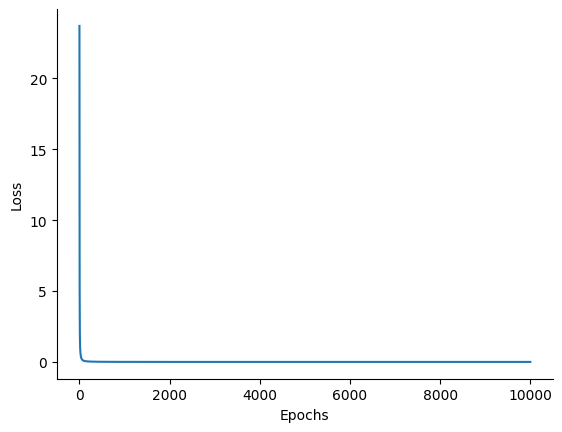

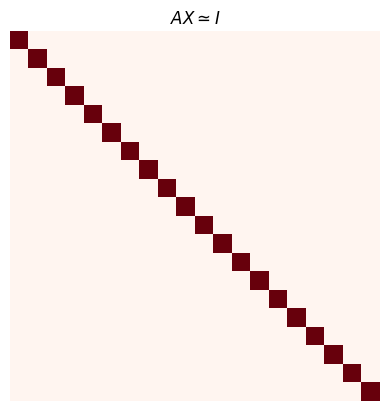

In [17]:
n_epochs = 10000
dim = 20
lr = 1

A = torch.randn(dim,dim)
I = torch.eye(dim)

X = torch.randn_like(A, requires_grad=True)

loss_fn = nn.MSELoss()

losses = np.zeros(n_epochs)

for epoch in tqdm(range(n_epochs)):
    loss = loss_fn(A@X, I)
    loss.backward()
    losses[epoch] = loss.item()
    with torch.no_grad():
        X -= lr * X.grad
    X.grad.zero_()
    


plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.yscale('log')
plt.show()

res = A @ X.detach()
res = (res - res.min()) / (res.max()-res.min())

plt.figure()
plt.title('$AX\simeq I$')
plt.imshow(res, cmap='Reds')
plt.axis('off')
plt.show()